In [1]:
from tqdm import tqdm
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.datasets import load_digits

this example is from https://indico.io/blog/tensorflow-data-inputs-part1-placeholders-protobufs-queues/
with some modifications

In [3]:
data = load_digits()

there are 1797 images in the data set. each image is 8 x 8

In [4]:
print(data.data.shape, type(data.data), data.target.shape, type(data.target))

(1797, 64) <class 'numpy.ndarray'> (1797,) <class 'numpy.ndarray'>


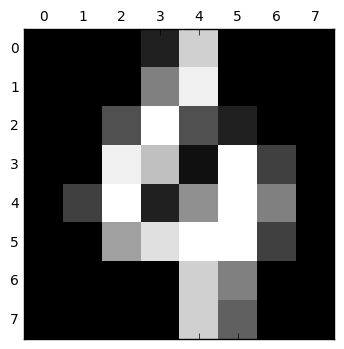

In [5]:
plt.gray()
plt.matshow(data.images[100]) # each image is 8 x 8, 64 pixels

# write image in TFRecord format

TFRecord is a binary format of tensorflow. we use TFRecords so that data can be read from disk to memory in a stream fashion. this is extremely important for large dataset where they cannot fit in memory all at once

In [6]:
writer = tf.python_io.TFRecordWriter("mnist.tfrecords")

in the following code, image is written to TFRecord one by one.

In [7]:
for example_idx in tqdm(range(data.data.shape[0])):
    features = data.data[example_idx]
    label = data.target[example_idx]

    # construct the Example proto boject
    example = tf.train.Example(
        # Example contains a Features proto object
        features=tf.train.Features(
          # Features contains a map of string to Feature proto objects
          feature={
            # A Feature contains one of either a int64_list,
            # float_list, or bytes_list
            'label': tf.train.Feature(
                int64_list=tf.train.Int64List(value=[label.tolist()])),
            'image': tf.train.Feature(
                int64_list=tf.train.Int64List(value=features.astype(int).tolist())),
    }))
    # use the proto object to serialize the example to a string
    serialized = example.SerializeToString()
    # write the serialized object to disk
    writer.write(serialized)

100%|████████████████████████████████████| 1797/1797 [00:01<00:00, 1650.26it/s]


# read data in TFRecord format

we can also read image one by one. It works but not efficient

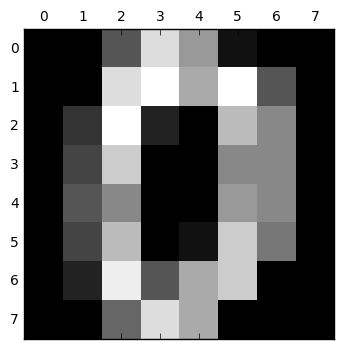

In [8]:
filename = "mnist.tfrecords"
for serialized_example in tf.python_io.tf_record_iterator(filename):
    example = tf.train.Example()
    example.ParseFromString(serialized_example)

    # traverse the Example format to get data
    image = example.features.feature['image'].int64_list.value
    label = example.features.feature['label'].int64_list.value[0]
    # do something
    #print(image, label)
    image = np.array(image).reshape([8,8])
    plt.matshow(image)
    break

In [9]:
def read_and_decode_single_example(filename):
    # first construct a queue containing a list of filenames.
    # this lets a user split up there dataset in multiple files to keep
    # size down
    filename_queue = tf.train.string_input_producer([filename],
                                                    num_epochs=None)
    # Unlike the TFRecordWriter, the TFRecordReader is symbolic
    reader = tf.TFRecordReader()
    # One can read a single serialized example from a filename
    # serialized_example is a Tensor of type string.
    _, serialized_example = reader.read(filename_queue)
    # The serialized example is converted back to actual values.
    # One needs to describe the format of the objects to be returned
    features = tf.parse_single_example(
        serialized_example,
        features={
            # We know the length of both fields. If not the
            # tf.VarLenFeature could be used
            'label': tf.FixedLenFeature([], tf.int64),
            'image': tf.FixedLenFeature([64], tf.int64)
        })
    # now return the converted data
    label = features['label']
    image = features['image']
    return label, image

In [10]:
# returns symbolic label and image
label, image = read_and_decode_single_example("mnist.tfrecords")

sess = tf.Session()

# Required. See below for explanation
init = tf.global_variables_initializer()
sess.run(init)
tf.train.start_queue_runners(sess=sess)

[<Thread(Thread-7, started daemon 15268)>]

<class 'numpy.int64'> <class 'numpy.ndarray'> () (64,)


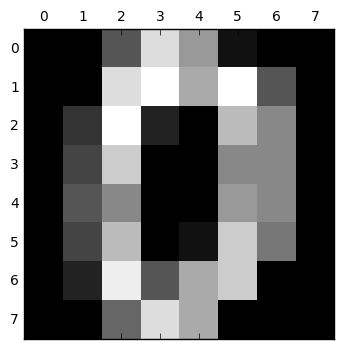

In [11]:
# grab examples back.
# first example from file
label_val_1, image_val_1 = sess.run([label, image])
print(type(label_val_1), type(image_val_1), label_val_1.shape, image_val_1.shape)
image_val_1 = np.array(image_val_1).reshape([8,8])
plt.matshow(image_val_1)

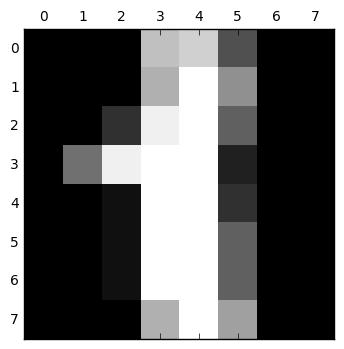

In [12]:
# second example from file
label_val_2, image_val_2 = sess.run([label, image])
image_val_2 = np.array(image_val_2).reshape([8,8])
plt.matshow(image_val_2)

In [13]:
# get single examples
label, image = read_and_decode_single_example("mnist.tfrecords")
# groups examples into batches randomly
images_batch, labels_batch = tf.train.shuffle_batch(
    [image, label], batch_size=128,
    capacity=2000,
    min_after_dequeue=1000)

sess = tf.Session()
init = tf.initialize_all_variables()
sess.run(init)
tf.train.start_queue_runners(sess=sess)
labels, images= sess.run([labels_batch, images_batch])

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [14]:
print(labels.shape, images.shape)
print (type(images_batch))

(128,) (128, 64)
<class 'tensorflow.python.framework.ops.Tensor'>


In [15]:
# simple model
w = tf.get_variable("w1", [8*8, 10])
images_batch = tf.cast(images_batch, tf.float32)
y_pred = tf.matmul(images_batch, w)
loss = tf.nn.sparse_softmax_cross_entropy_with_logits(y_pred, labels_batch)

# for monitoring
loss_mean = tf.reduce_mean(loss)

train_op = tf.train.AdamOptimizer().minimize(loss)

sess = tf.Session()
init = tf.initialize_all_variables()
sess.run(init)
tf.train.start_queue_runners(sess=sess)

for i in range(10):
  # pass it in through the feed_dict
  _, loss_val = sess.run([train_op, loss_mean])
  print(loss_val)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
10.5527
9.83923
9.93795
9.15298
9.231
8.88087
9.12664
8.47488
8.78901
8.30016
